In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import missingno as msn
plt.rcParams['font.sans-serif'] = ['STSong']
plt.rcParams['figure.dpi'] = 150
from warnings import filterwarnings
filterwarnings('ignore')
import matplotlib
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
import chinese_calendar

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, log_loss, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import StratifiedKFold 
%matplotlib inline
from functools import partial
from skopt import gp_minimize
from skopt import space
from skopt.plots import plot_convergence

In [36]:
df_train = pd.read_csv('D:/ProgrammingLeaning/JupyterLearning/order_train1.csv')
df_train.head()

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty
0,2015-09-01,104,22069,307,403,offline,1114.0,19
1,2015-09-01,104,20028,301,405,offline,1012.0,12
2,2015-09-02,104,21183,307,403,online,428.0,109
3,2015-09-02,104,20448,308,404,online,962.0,3
4,2015-09-02,104,21565,307,403,offline,1400.0,3


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 597694 entries, 0 to 597693
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_date         597694 non-null  object 
 1   sales_region_code  597694 non-null  int64  
 2   item_code          597694 non-null  int64  
 3   first_cate_code    597694 non-null  int64  
 4   second_cate_code   597694 non-null  int64  
 5   sales_chan_name    597694 non-null  object 
 6   item_price         597694 non-null  float64
 7   ord_qty            597694 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 36.5+ MB


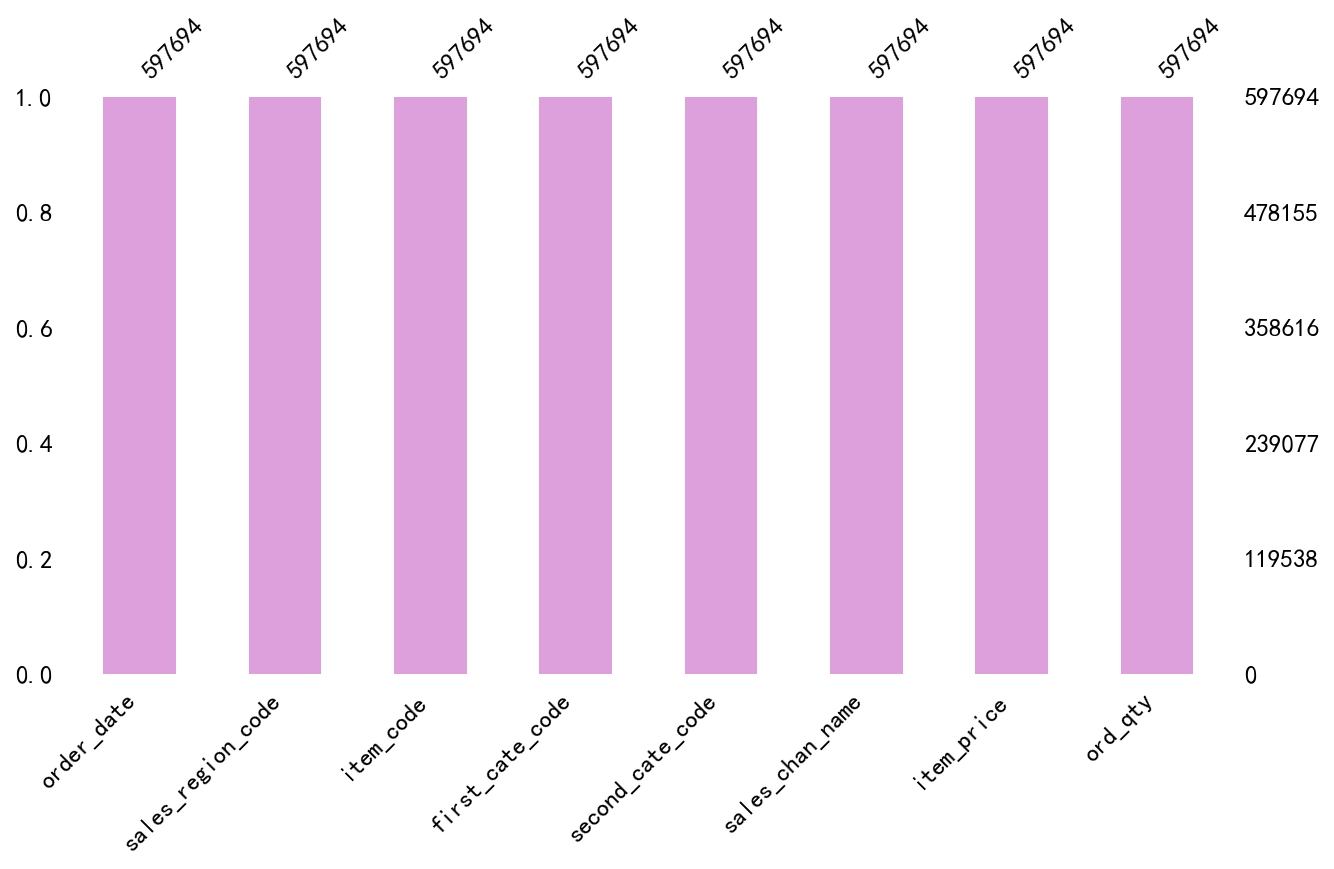

In [6]:
#查看缺失值
missingno.bar(df_train,color="plum", sort="ascending", figsize=(10,5), fontsize=12);

In [42]:
## 去重处理
df_train.drop_duplicates(inplace=True)
df_train.describe()

,sales_region_code,item_code,first_cate_code,second_cate_code,item_price,ord_qty
count,597382.000000,597382.000000,597382.000000,597382.000000,597382.000000,597382.000000
mean,102.904318,21008.029884,304.932141,406.457362,1076.141512,91.683901
std,1.505023,590.908646,2.004253,3.107303,1167.576590,199.887129
min,101.000000,20001.000000,301.000000,401.000000,1.000000,1.000000
25%,102.000000,20518.000000,303.000000,404.000000,598.000000,10.000000
50%,103.000000,20976.000000,306.000000,407.000000,883.000000,29.000000
75%,105.000000,21521.000000,306.000000,408.000000,1291.000000,101.000000
max,105.000000,22084.000000,308.000000,412.000000,260014.000000,16308.000000


Text(0.5, 1.0, 'item_price')

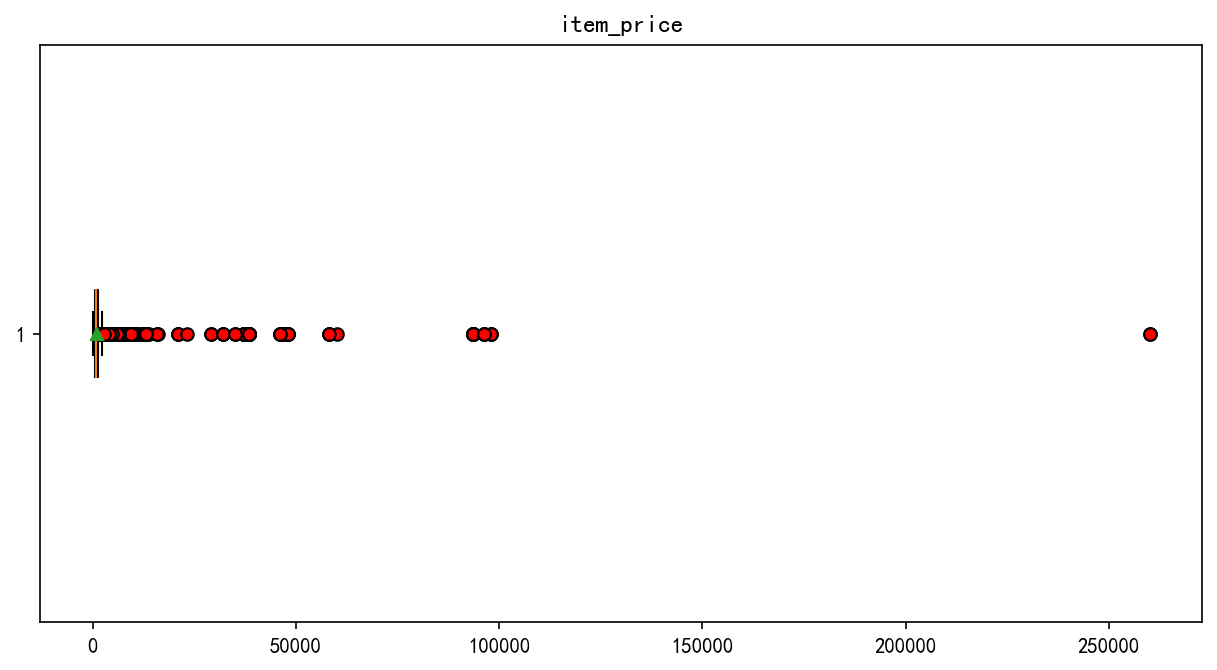

In [40]:
#产品价格特征异常值检查
plt.figure(figsize=(10,5))
plt.rcParams['font.sans-serif']='simhei'
plt.rcParams['axes.unicode_minus']=False
a1 = plt.boxplot(df_train['item_price'],vert=False,showmeans=True,flierprops={"marker":"o","markerfacecolor":"red"})
plt.title('item_price')

Text(0.5, 1.0, 'ord_qty')

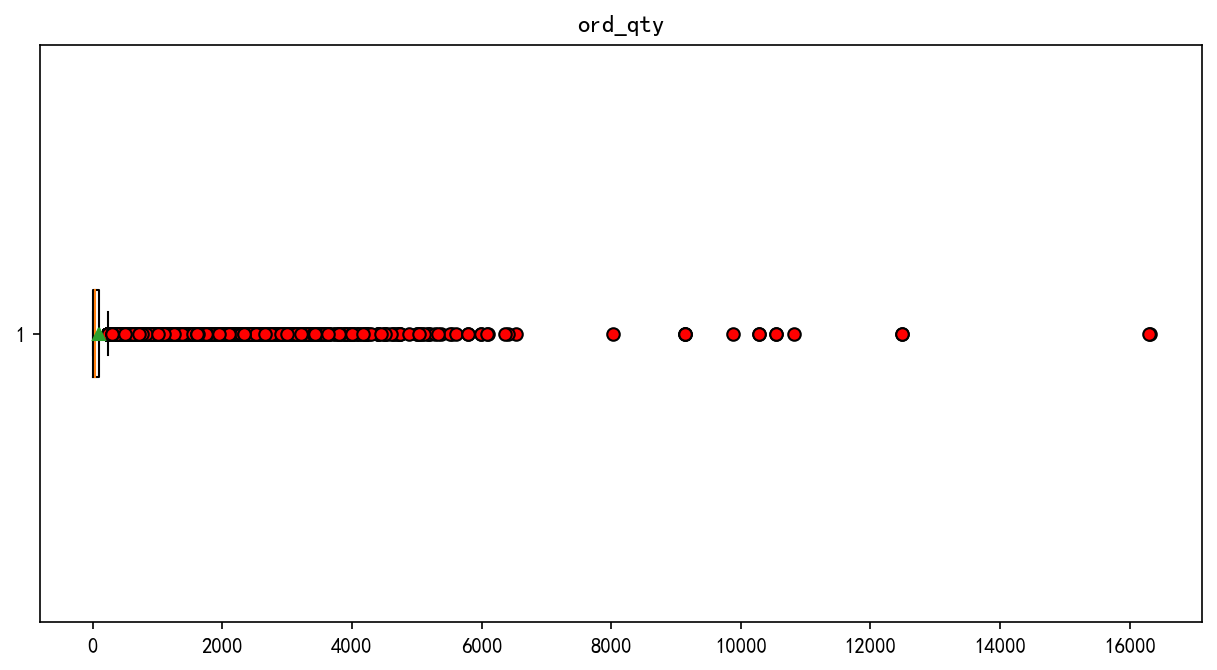

In [43]:
#需求量异常值： 在df.describe()中可以知道需求量有max16308
#产品价格特征异常值检查
plt.figure(figsize=(10,5))
plt.rcParams['font.sans-serif']='simhei'
plt.rcParams['axes.unicode_minus']=False
a1 = plt.boxplot(df_train['ord_qty'],vert=False,showmeans=True,flierprops={"marker":"o","markerfacecolor":"red"})
plt.title('ord_qty')

In [ ]:
#数据预处理
# 新增8个特征Year、Month、day、week、weekday、season、month_phase、is_holiday


In [44]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import holidays


def extract_date_features(data):
    """
    提取日期特征。
    :param data: pandas DataFrame
    :return: 添加了日期特征的数据框
    """
    if "order_date" in data.columns:
        data["order_date"] = pd.to_datetime(data["order_date"])
    data["Year"] = data["order_date"].dt.year
    data["Month"] = data["order_date"].dt.month
    data["day"] = data["order_date"].dt.day
    data["week"] = data["order_date"].dt.weekofyear
    data["weekday"] = data["order_date"].dt.weekday
    # 基于北半球的季节划分
    data["season"] = data["Month"].apply(lambda x: (x % 12 + 3) // 3)
    return data

def add_month_phase_feature(data, date_column):
    """
    添加月份阶段特征。
    :param data: pandas DataFrame
    :param date_column: 用于提取月份阶段的日期列名称
    :return: 添加了月份阶段特征的数据框
    """

    def categorize_month_phase(day):
        if day <= 10:
            return "Early Month"
        elif day <= 20:
            return "Mid Month"
        else:
            return "End of Month"

    data["month_phase"] = data[date_column].dt.day.apply(categorize_month_phase)
    return data


def add_holiday_feature(data, years):
    """
    为数据集添加假日特征。
    :param data: pandas DataFrame
    :param years: 年份列表
    :return: 添加了假日特征的数据框
    """
    cn_holidays = holidays.CN(years=years)
    data["is_holiday"] = data["order_date"].apply(lambda x: x in cn_holidays)
    return data

def add_season_feature(data):
    """
    添加季节特征，假设北半球的季节。
    :param data: pandas DataFrame
    :return: 添加了季节特征的数据框
    """

    def get_season(month):
        if month in [3, 4, 5]:
            return "Spring"
        elif month in [6, 7, 8]:
            return "Summer"
        elif month in [9, 10, 11]:
            return "Fall"
        else:
            return "Winter"

    data["season"] = data["Month"].apply(get_season)
    return data


def mark_promotions(data):
    """
    标记促销日。
    :param data: pandas DataFrame
    :return: 标记了促销日的数据框
    """
    # 定义促销日期
    promo_dates = {(2,14),(3,8),(6, 18), (11, 11), (12, 12)}  # 618、双十一、双十二
    # 标记促销日
    data["is_promo"] = data["order_date"].apply(
        lambda x: (x.month, x.day) in promo_dates
    )
    return data



In [47]:
def preprocess_data(data, date_column):
    """
    执行数据预处理
    :param data: pandas DataFrame
    :param date_column: 日期列名称
    :return: 添加了特征的数据框
    Year、Month、day、week、标签(月初中末)、是否节假日

    """
    data = extract_date_features(data)
    data = add_month_phase_feature(data, date_column)
    unique_years = data[date_column].dt.year.unique()
    data = add_holiday_feature(data, list(unique_years))
    data = add_season_feature(data)

    print("数据预处理完成")
    return data

def main():
    # 加载数据
    file_path = "D:/ProgrammingLeaning/JupyterLearning/order_train1.csv"
    data = pd.read_csv(file_path)
    date_column = "order_date" #日期列
    
    # 转换日期列
    data[date_column] = pd.to_datetime(data[date_column])
    
    ## 去重处理
    data.drop_duplicates(inplace=True)
    
    #删除掉两个异常值(价格)
    data=data[data['item_price'] <100000] #去掉26万的异常值
    #删除异常值（需求量）
    data=data[data['ord_qty'] <6000]
    
    #预处理数据， Year、Month、day、week、标签(月初中末)"month_phase"、是否节假日"is_holiday"
    preprocessed_data = preprocess_data(data,date_column)
    print("preprocessing raw data is done!")

    # 保存预处理数据
    preprocessed_data.to_csv("D:/ProgrammingLeaning/JupyterLearning/产品订单processed_data/processed_data0622.csv", index=False)
    print("Preprocessed data is saved in folder 产品订单processed_data0620")
    return preprocessed_data

if __name__ == "__main__":
    main()

数据预处理完成
preprocessing raw data is done!
Preprocessed data is saved in folder 产品订单processed_data0620


In [48]:
def construct_2019_january_data(predict_2019):
    """
    构造2018年12月21日至2019年1月的数据表。
    :param predict_2019: DataFrame, 包含销售区域编码、商品编码、大类编码和细类编码
    :return: pandas DataFrame, 构造好的2018年12月21日至2019年1月的数据表
    """
    dates = pd.date_range(start='2018-12-21', end='2019-01-31')
    data_list = []
    for date in dates:
        for _, row in predict_2019.iterrows():
            data_list.append([date, row['sales_region_code'], row['item_code'],row['first_cate_code'], row['second_cate_code'], 0])  # ord_qty初始为0
    data_2019 = pd.DataFrame(data_list, columns=['order_date', 'sales_region_code', 'item_code', 'first_cate_code', 'second_cate_code', 'ord_qty'])
    return data_2019

#加载待预测数据
predict_2019 = pd.read_csv('D:/ProgrammingLeaning/JupyterLearning/predict_sku1.csv')
# 构造2019年1月数据表
data_2019 = construct_2019_january_data(predict_2019)

print(f"构造出来的数据条数: {len(data_2019)}")
print(data_2019.head())  # 打印前几行数据以进行检查
data_2019.to_csv("D:/ProgrammingLeaning/JupyterLearning/产品订单processed_data/data_20181221_2019_raw.csv", index=False)

构造出来的数据条数: 109998
  order_date  sales_region_code  item_code  first_cate_code  second_cate_code  \
0 2018-12-21                101      20002              303               406   
1 2018-12-21                101      20003              301               405   
2 2018-12-21                101      20006              307               403   
3 2018-12-21                101      20011              303               401   
4 2018-12-21                101      20014              307               403   

   ord_qty  
0        0  
1        0  
2        0  
3        0  
4        0  


In [49]:
data_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109998 entries, 0 to 109997
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   order_date         109998 non-null  datetime64[ns]
 1   sales_region_code  109998 non-null  int64         
 2   item_code          109998 non-null  int64         
 3   first_cate_code    109998 non-null  int64         
 4   second_cate_code   109998 non-null  int64         
 5   ord_qty            109998 non-null  int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 5.0 MB


In [51]:
def main():
    # 加载数据
    file_path = "D:/ProgrammingLeaning/JupyterLearning/产品订单processed_data/data_20181221_2019_raw.csv"
    data = pd.read_csv(file_path)
    date_column = "order_date" #日期列
    
    # 转换日期列
    data[date_column] = pd.to_datetime(data[date_column])
    
    ## 去重处理
    data.drop_duplicates(inplace=True)
    
    #预处理数据， Year、Month、day、week、标签(月初中末)"month_phase"、是否节假日"is_holiday"
    preprocessed_data = preprocess_data(data,date_column)
    print("preprocessing raw data is done!")

    # 保存预处理数据
    preprocessed_data.to_csv("D:/ProgrammingLeaning/JupyterLearning/产品订单processed_data/processed_20181221_2019_data0622.csv", index=False)
    print("Preprocessed data is saved in folder 产品订单processed_20181221_2019_data")
    return preprocessed_data

if __name__ == "__main__":
    main()

数据预处理完成
preprocessing raw data is done!
Preprocessed data is saved in folder 产品订单processed_20181221_2019_data


In [52]:
import joblib

#原始数据
data = pd.read_csv('D:/ProgrammingLeaning/JupyterLearning/产品订单processed_data/processed_data0622.csv',encoding='utf-8')
data['order_date'] = pd.to_datetime(data['order_date'])
data = data.sort_values(by='order_date')

data_2019 = pd.read_csv("D:/ProgrammingLeaning/JupyterLearning/产品订单processed_data/processed_20181221_2019_data0622.csv")

# 将2019年数据与历史数据拼接
combined_data = pd.concat([data, data_2019], ignore_index=True)
combined_data 
combined_data.to_csv("D:/ProgrammingLeaning/JupyterLearning/产品订单processed_data/processed_2015to2019_01_data0622.csv")

In [53]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707359 entries, 0 to 707358
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_date         707359 non-null  object 
 1   sales_region_code  707359 non-null  int64  
 2   item_code          707359 non-null  int64  
 3   first_cate_code    707359 non-null  int64  
 4   second_cate_code   707359 non-null  int64  
 5   sales_chan_name    597361 non-null  object 
 6   item_price         597361 non-null  float64
 7   ord_qty            707359 non-null  int64  
 8   Year               707359 non-null  int64  
 9   Month              707359 non-null  int64  
 10  day                707359 non-null  int64  
 11  week               707359 non-null  int64  
 12  weekday            707359 non-null  int64  
 13  season             707359 non-null  object 
 14  month_phase        707359 non-null  object 
 15  is_holiday         707359 non-null  bool   
dtypes: